# Predicting beer consumption

## Importing required modules

In [106]:
# Install packages for the project
#!pip install pandas numpy seaborn matplotlib scikit-learn scipy

In [107]:
#pip install seaborn

In [108]:
#pip install scikit-learn

In [109]:
# Import the required building blocks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.metrics import f1_score

# Beer consumption as a classification issue
Let's try to predict whether "very little", "little", "much" or "very much" beer is drunk; A classification.

To this end, the data is processed in which the number of Litres is divided into four classes.
The limit of the classes is roughly based on the quartile distribution.

- I: under 22,000 Litres
- II: between 22,000 and 25,000 Litres
- III: between 25,000 and 29,000 Litres
- IV: More than 29,000 Litres

If all goes well, these classes are of comparable size (i.e. somewhat balanced).

## Data analysis and preprocessing

In [110]:
# Back to the source
df = pd.read_csv('Beerconsumption.csv')

In [111]:
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         365 non-null    object 
 1   AvgTemp      365 non-null    float64
 2   MinTemp      365 non-null    float64
 3   MaxTemp      365 non-null    float64
 4   Rainfall_mm  365 non-null    float64
 5   Weekend      365 non-null    int64  
 6   Litres       365 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


In [113]:
df.describe()

,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,0.284932,25401.367123
std,3.180108,2.826185,4.317366,12.417844,0.452001,4399.142703
min,12.900000,10.600000,14.500000,0.000000,0.000000,14343.000000
25%,19.020000,15.300000,23.800000,0.000000,0.000000,22008.000000
50%,21.380000,17.900000,26.900000,0.000000,0.000000,24867.000000
75%,23.280000,19.600000,29.400000,3.200000,1.000000,28631.000000
max,28.860000,24.500000,36.500000,94.800000,1.000000,37937.000000


In [114]:
df.dropna(inplace=True)
df.Date = pd.to_datetime(df.Date)
df.Weekend = df.Weekend.astype(int)

array([[<Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'AvgTemp'}>,
        <Axes: title={'center': 'MinTemp'}>],
       [<Axes: title={'center': 'MaxTemp'}>,
        <Axes: title={'center': 'Rainfall_mm'}>,
        <Axes: title={'center': 'Weekend'}>],
       [<Axes: title={'center': 'Litres'}>, <Axes: >, <Axes: >]],
      dtype=object)

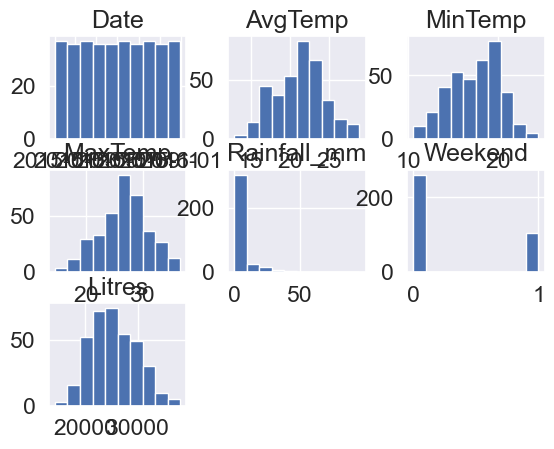

In [115]:
df.hist()

### Making classes

In [116]:
# Making the classes (this is one method, many exist)
df['Class1'] = np.where(df['Litres'] > 29000, 1, 0)
df['Class2'] = np.where(df['Litres'] > 25000, 1, 0)
df['Class3'] = np.where(df['Litres'] > 22000, 1, 0)
df['Class4'] = np.where(df['Litres'] > 10000, 1, 0)

df['Class'] = df.Class1 + df.Class2 + df.Class3 + df.Class4
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class1,Class2,Class3,Class4,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,0,1,1,1,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,0,1,1,1,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,1,1,1,1,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,1,1,1,1,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,0,1,1,1,3


In [117]:
# The auxiliary columns can leave again
df.drop(columns=['Class1', 'Class2', 'Class3', 'Class4'], inplace=True)
df.head()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class
0,2015-01-01,27.30,23.9,32.5,0.0,0,25461.0,3
1,2015-01-02,27.02,24.5,33.5,0.0,0,28972.0,3
2,2015-01-03,24.82,22.4,29.9,0.0,1,30814.0,4
3,2015-01-04,23.98,21.5,28.6,1.2,1,29799.0,4
4,2015-01-05,23.82,21.0,28.3,0.0,0,28900.0,3


      Litres                                                       
       count        sum     mean     std      min   median      max
Class                                                              
1         90  1808614.0  20095.7  1672.7  14343.0  20597.5  21979.0
2         98  2309777.0  23569.2   942.3  22001.0  23551.5  24974.0
3         95  2560159.0  26949.0  1163.6  25070.0  26828.0  28979.0
4         82  2592949.0  31621.3  1985.8  29090.0  31134.0  37937.0


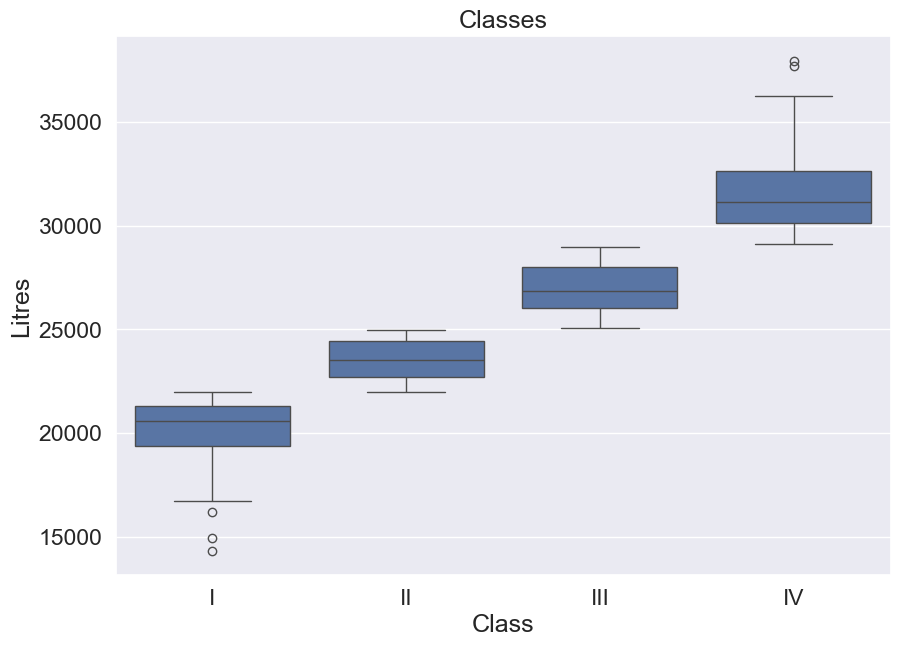

In [118]:
# Just a check of the number of Litres per class
perClass = df.groupby('Class').agg({'Litres':['count','sum','mean','std','min','median', 'max']}).round(1)
print(perClass)

plt.figure(figsize=(10,7))
sns.boxplot(x="Class", y="Litres", data=df)
plt.xticks(range(0,4),["I", "II", "III", "IV"])
plt.title("Classes")
plt.show()

### 1. Feature selection
Is the Date a useful feature for our goal? Would another be useful? How can you check?

In [119]:
# Let's add the season, because why not
df['Season'] = df.Date.dt.month.map({1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4, 12:1})

In [120]:
df['Month'] = df.Date.dt.month

In [121]:
df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

df["Weekday"] = df["Date"].dt.dayofweek + 1
df["Weekday_sin"] = np.cos(2 * np.pi * df["Weekday"] / 7)
df["Weekday_cos"] = np.cos(2 * np.pi * df["Weekday"] / 7)

In [122]:
#pip install holidays

In [123]:
import pandas as pd
import holidays

# dataframe com coluna Date em datetime
df["Date"] = pd.to_datetime(df["Date"])

# instância da lista de feriados — por exemplo, Brasil
br_holidays = holidays.Brazil()

# cria a coluna binária
df["HolyDay"] = df["Date"].apply(lambda d: 1 if d in br_holidays else 0)

In [124]:
df.tail()

,Date,AvgTemp,MinTemp,MaxTemp,Rainfall_mm,Weekend,Litres,Class,Season,Month,Month_sin,Month_cos,Weekday,Weekday_sin,Weekday_cos,HolyDay
360,2015-12-27,24.00,21.1,28.2,13.6,1,32307.0,4,1,12,-2.449294e-16,1.0,7,1.000000,1.000000,0
361,2015-12-28,22.64,21.1,26.7,0.0,0,26095.0,3,1,12,-2.449294e-16,1.0,1,0.623490,0.623490,0
362,2015-12-29,21.68,20.3,24.1,10.3,0,22309.0,2,1,12,-2.449294e-16,1.0,2,-0.222521,-0.222521,0
363,2015-12-30,21.38,19.3,22.4,6.3,0,20467.0,1,1,12,-2.449294e-16,1.0,3,-0.900969,-0.900969,0
364,2015-12-31,24.76,20.2,29.0,0.0,0,22446.0,2,1,12,-2.449294e-16,1.0,4,-0.900969,-0.900969,0


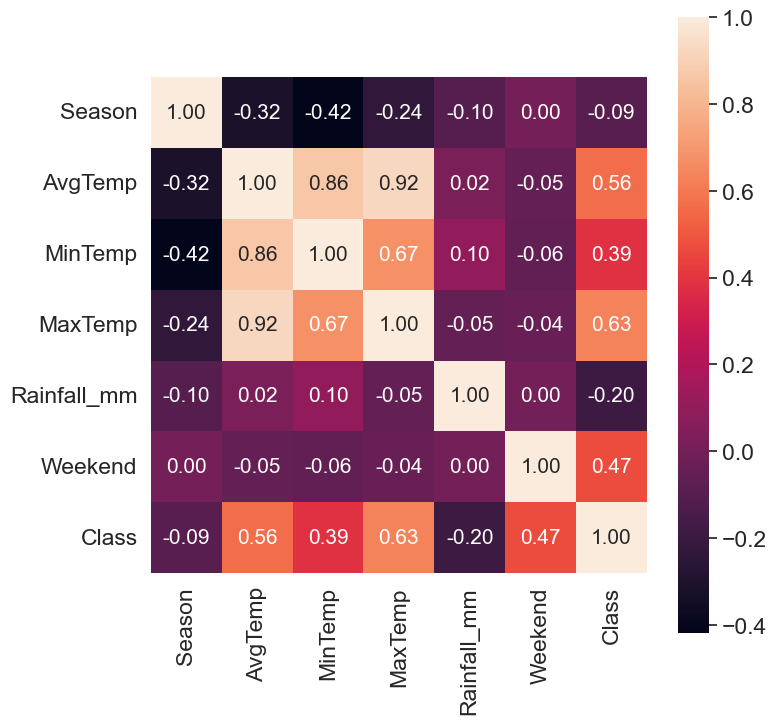

In [125]:
# Plot the correlation matrix for all features except the date
kolomdf = ['Season', 'AvgTemp', 'MinTemp', 'MaxTemp', 'Rainfall_mm', 'Weekend', 'Class']

plt.figure(figsize=(8,8))
cm = np.corrcoef(df[kolomdf].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15},
                yticklabels=kolomdf,
                xticklabels=kolomdf
                )
plt.show()

We'll make a simple model, using only MaxTemp and Weekend as features. AvgTemp and MinTemp are too strongly correlated with MaxTemp, and Rainfall and Season are only very weakly correlated with Class.

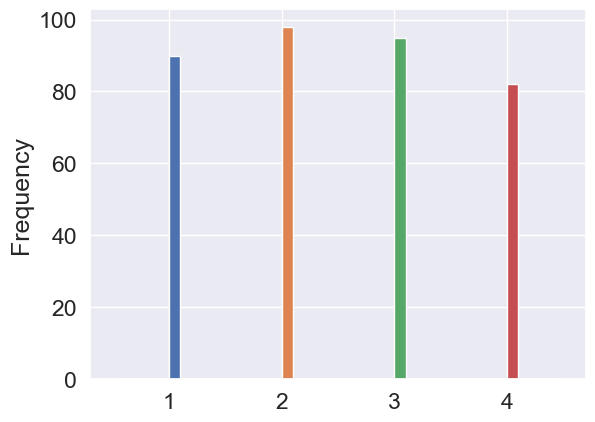

In [126]:
# We'll use as the predictors/features/independent variables MaxTemp and Weekend,
# and the class is the value to be predicted (label/independent var)
labels = df.loc[:,'Class']
data = df.loc[:,['MaxTemp', 'Weekend', 'Month_sin', 'Month_cos', 'Weekday_sin', 'Weekday_cos']]

# Insight into the frequency distribution of the classes;
# They are roughly balanced (as intended)
labels[:].groupby(labels[:]).plot(kind="hist")
plt.show()

# Function that plots the confusion matrix

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot a confusion matrix using seaborn heatmap.

    Parameters
    ----------
    y_true : array-like
        True class labels.
    y_pred : array-like
        Predicted class labels.
    model_name : str, optional
        Title for the plot (default is "Model").
    """
    # Compute confusion matrix
    confmat = confusion_matrix(y_true, y_pred)
    ticks = np.unique(np.concatenate((y_true, y_pred)))
    ticks.sort()

    # Create a seaborn heatmap
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        confmat,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=ticks,
        yticklabels=ticks,
        square=True
    )

    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

## 2. Baseline models for classification
Code a baseline model

In [128]:
# splits the dataset in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=0)


# give the size of the training and the test set again
print('shape of training set: ', X_train.shape)
print('shape of test set:     ', X_test.shape)

shape of training set:  (273, 6)
shape of test set:      (92, 6)


Accuracy: 0.5978260869565217


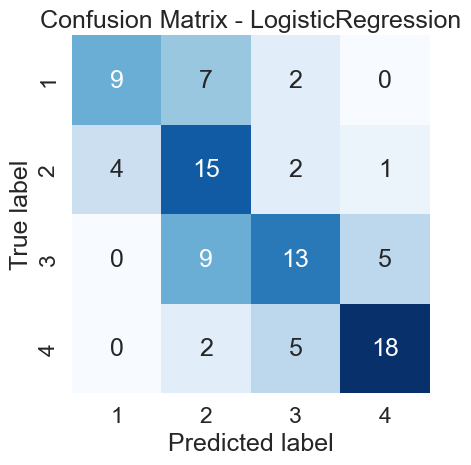

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 2.1 Choose a baseline classification model, fill in the blank
lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

lr_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', lr_acc)

plot_confusion_matrix(y_test, y_pred, model_name="LogisticRegression")


Accuracy: 0.4673913043478261


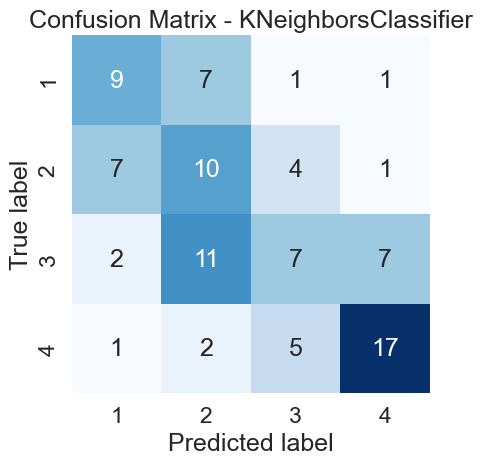

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', knn_acc)

plot_confusion_matrix(y_test, y_pred, model_name="KNeighborsClassifier")


#### Question: how do these models compare? Is there a difference in accuracy? Why do you think this is?

## 3/4. Tree-based models
Code a decision tree and random forest below!

Accuracy: 0.4673913043478261


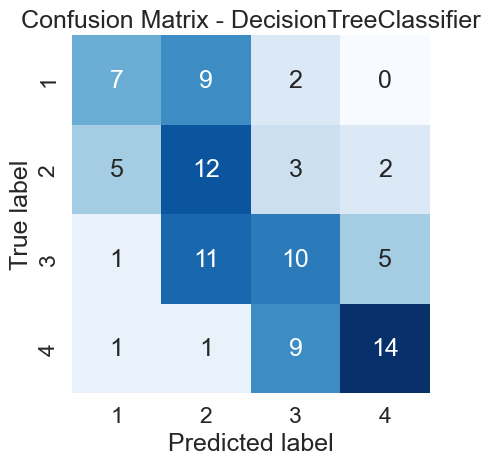

In [131]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Fill in the blank with a decision tree model
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

dt_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', dt_acc)

plot_confusion_matrix(y_test, y_pred, model_name="DecisionTreeClassifier")


Accuracy: 0.5108695652173914


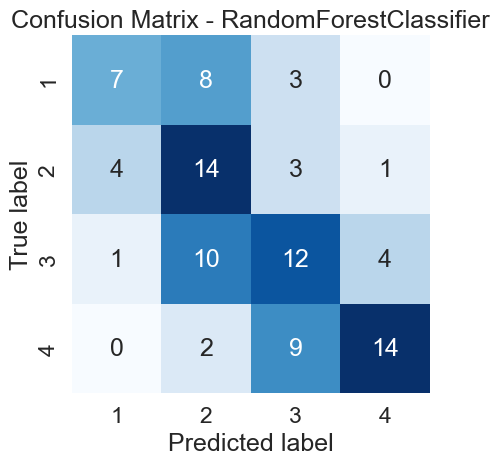

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fill in the blank with a random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred)
print('Accuracy:', rf_acc)

plot_confusion_matrix(y_test, y_pred, model_name="RandomForestClassifier")

In [133]:
print('Logistic Regression Accuracy:', lr_acc)
print('kNN Accuracy:', knn_acc)
print('Decicion Tree Accuracy:', dt_acc)
print('Random Forest Accuracy:', rf_acc)

Logistic Regression Accuracy: 0.5978260869565217
kNN Accuracy: 0.4673913043478261
Decicion Tree Accuracy: 0.4673913043478261
Random Forest Accuracy: 0.5108695652173914
